In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle

In [11]:
train_df = pd.read_csv('train.csv')

In [16]:
train_df.head()

,Содержание,Сервис,Приоритет,Статус,Функциональная группа,Крайний срок,Дата обращения,Тип обращения на момент подачи,Тип обращения итоговый,Решение,Тип переклассификации,Дата восстановления,Дата закрытия обращения,Критичность,Влияние,Система,Место
0,Тест,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 07:42,2018-01-19 09:27,Запрос,Запрос,Тест,0,NaN,2018-01-19 09:43,4-Нет,3-Малое,База,К
1,Тестовое обращение,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 10:51,2018-01-19 09:36,Запрос,Запрос,Тест,0,NaN,2018-01-19 09:41,4-Нет,3-Малое,База,К
2,Выполнена разблокировка у/з REGION\*****,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:51,2018-01-25 22:47,Запрос,Запрос,Выполнена разблокировка у/з Ne_bosS\*********\...,0,2018-01-25 22:47,2018-02-02 07:52,1-Особая,3-Малое,Система7,Место190
3,.Не включается ПК,АРМ,3-Низкий,Закрыт,ФГ390,2018-01-28 05:50,2018-01-25 23:13,Инцидент,Инцидент,Выход из стоя БП. Заменён.,0,2018-01-25 23:55,2018-01-26 00:00,4-Нет,3-Малое,База,Место177
4,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ303,2018-02-03 02:51,2018-01-25 23:39,Запрос,Запрос,Работы по обращению выполнены,0,2018-01-28 02:54,2018-02-04 07:53,4-Нет,4-Нет влияния,База,Место216


In [3]:
train_df_slice = train_df[train_df['Тип переклассификации'] == 0][:750]
train_df_slice = pd.concat([train_df_slice, train_df[train_df['Тип переклассификации'] == 1]])
train_df_slice = pd.concat([train_df_slice, train_df[train_df['Тип переклассификации'] == 2]])
train_df_slice = train_df_slice.sample(frac=1).reset_index(drop=True)
train_df_slice.shape

(1108, 17)

In [4]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import joblib


# Инициализация инструментов NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Удаление стоп-слов
stop_words = set(stopwords.words('russian'))

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для обработки текста
def process_text(text):
    # Приведение текста к нижнему регистру
    #print(text)
    text = text.lower()
    # Токенизация текста
    tokens = nltk.word_tokenize(text, language='russian')
    # Удаление стоп-слов и пунктуации
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    # Лемматизация токенов
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Соединение токенов обратно в текст
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# Применение функции обработки текста к столбцу "Содержание"
processed_content = train_df_slice['Содержание'].apply(process_text)

# Применение функции обработки текста к столбцу "Решение"
processed_solution = train_df_slice['Решение             '].apply(process_text)

# Пример преобразования текста в числовое представление с помощью Bag-of-Words для столбца "Содержание"
vectorizer_content = CountVectorizer()
vectorizer_content.fit(processed_content)
joblib.dump(vectorizer_content, 'vectorizer_content.pkl')

# Пример преобразования текста в числовое представление с помощью Bag-of-Words для столбца "Решение"
vectorizer_solution = CountVectorizer()
vectorizer_solution.fit(processed_solution)
joblib.dump(vectorizer_solution, 'vectorizer_solution.pkl')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\exman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\exman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\exman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['vectorizer_solution.pkl']

In [5]:
# 0 — колонка будет дропнута
columns_action_dict = {'Содержание': vectorizer_content,
                       'Сервис': OneHotEncoder(handle_unknown='ignore'),
                       'Приоритет':  LabelEncoder(),
                       'Статус': LabelEncoder(),
                       'Функциональная группа': OneHotEncoder(handle_unknown='ignore'),
                       'Крайний срок': 0,
                       'Дата обращения': 0,
                       'Тип обращения на момент подачи': LabelEncoder(),
                       'Тип обращения итоговый': 0,
                       'Решение             ': vectorizer_solution,
                       'Тип переклассификации': 0,
                       'Дата восстановления': 0,
                       'Дата закрытия обращения': 0,
                       'Критичность': LabelEncoder(),
                       'Влияние': LabelEncoder(),
                       'Система': OneHotEncoder(handle_unknown='ignore'),
                       'Место': OneHotEncoder(handle_unknown='ignore')}

In [6]:
columns_action = pd.Series(columns_action_dict)

In [8]:
for col_name, action in zip(columns_action.index, columns_action.values):
    if type(action) == type(OneHotEncoder()) or type(action) == type(LabelEncoder()):
        action.fit(train_df[[col_name]])

C:\Users\exman\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\exman\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\exman\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\exman\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [9]:
with open('columns_action.pkl','wb') as outp:
    pickle.dump(columns_action, outp)

In [9]:
def proccess_df(df, columns_action):
    y = df['Тип переклассификации']
    y.replace(2, 1, inplace=True)
    
    for col_name, action in zip(columns_action.index, columns_action.values):
        if action == 0:
            df.drop(col_name, axis=1, inplace=True)
        elif type(action) == type(OneHotEncoder()):
            df[col_name] = action.transform(df[[col_name]]).toarray().tolist()
        elif type(action) == type(LabelEncoder()):
            df[col_name] = action.transform(df[col_name])
        elif type(action) == type(CountVectorizer()):
            df[col_name] = action.transform(df[col_name].apply(process_text)).toarray().tolist()
            
    df_np = np.array(df)
    vector_len = len(np.hstack([df_np[0][j] for j in range(len(df_np[0]))]))
    x = np.empty([df_np.shape[0], vector_len])
    
    for i in range(len(x)):
        x[i] = np.hstack([df_np[i][j] for j in range(len(df_np[i]))])
    
    return x, y

In [10]:
x_train, y_train = proccess_df(train_df_slice, columns_action)

In [11]:
from sklearn.model_selection import train_test_split

xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.15)

In [12]:
model = keras.Sequential([
    keras.layers.Dense(32, activation='tanh', input_shape=(xx_train.shape[1],)),
    #keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='bce',
              metrics=['accuracy'])

In [13]:
history = model.fit(xx_train,
                    yy_train,
                    epochs=7,
                    verbose=1,
                    validation_data=(xx_test, yy_test))

Epoch 1/7
30/30 [==============================] - 2s 9ms/step - loss: 0.5007 - accuracy: 0.7269 - val_loss: 0.4009 - val_accuracy: 0.7904
Epoch 2/7
30/30 [==============================] - 0s 4ms/step - loss: 0.2658 - accuracy: 0.9416 - val_loss: 0.2641 - val_accuracy: 0.9162
Epoch 3/7
30/30 [==============================] - 0s 5ms/step - loss: 0.1617 - accuracy: 0.9660 - val_loss: 0.2037 - val_accuracy: 0.9341
Epoch 4/7
30/30 [==============================] - 0s 5ms/step - loss: 0.1110 - accuracy: 0.9798 - val_loss: 0.1752 - val_accuracy: 0.9461
Epoch 5/7
30/30 [==============================] - 0s 5ms/step - loss: 0.0800 - accuracy: 0.9883 - val_loss: 0.1673 - val_accuracy: 0.9401
Epoch 6/7
30/30 [==============================] - 0s 5ms/step - loss: 0.0670 - accuracy: 0.9862 - val_loss: 0.1465 - val_accuracy: 0.9521
Epoch 7/7
30/30 [==============================] - 0s 5ms/step - loss: 0.0478 - accuracy: 0.9915 - val_loss: 0.1384 - val_accuracy: 0.9461


In [14]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid(True)

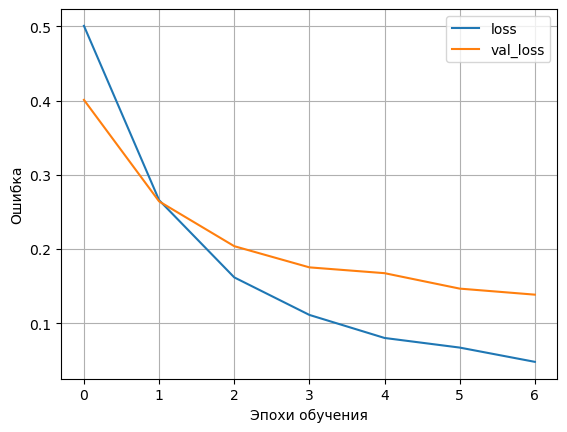

In [15]:
plot_loss(history)

In [16]:
model.save('model_mlp.h5')

In [17]:
import catboost
from catboost import * 

model1 = CatBoostClassifier(
    iterations=1639,
    random_seed=13,
    loss_function='CrossEntropy'
)

model1.fit(
    x_train, y_train,
    #eval_set=(X_test, y_test),
    verbose=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6592050	total: 171ms	remaining: 4m 39s
1:	learn: 0.6292376	total: 178ms	remaining: 2m 25s
2:	learn: 0.6020913	total: 187ms	remaining: 1m 41s
3:	learn: 0.5781585	total: 195ms	remaining: 1m 19s
4:	learn: 0.5537178	total: 203ms	remaining: 1m 6s
5:	learn: 0.5321909	total: 210ms	remaining: 57.2s
6:	learn: 0.5122605	total: 217ms	remaining: 50.7s
7:	learn: 0.4943435	total: 224ms	remaining: 45.6s
8:	learn: 0.4764497	total: 231ms	remaining: 41.8s
9:	learn: 0.4596507	total: 239ms	remaining: 38.9s
10:	learn: 0.4445607	total: 248ms	remaining: 36.7s
11:	learn: 0.4281818	total: 258ms	remaining: 35s
12:	learn: 0.4157311	total: 268ms	remaining: 33.5s
13:	learn: 0.4018925	total: 277ms	remaining: 32.1s
14:	learn: 0.3893884	total: 286ms	remaining: 30.9s
15:	learn: 0.3776772	total: 295ms	remaining: 29.9s
16:	learn: 0.3673129	total: 303ms	remaining: 28.9s
17:	learn: 0.3554623	total: 313ms	remaining: 28.2s
18:	learn: 0.3473583	total: 323ms	remaining: 27.5s
19:	learn: 0.3403719	total: 330ms	remai

173:	learn: 0.1142436	total: 1.61s	remaining: 13.6s
174:	learn: 0.1140764	total: 1.62s	remaining: 13.6s
175:	learn: 0.1139132	total: 1.63s	remaining: 13.5s
176:	learn: 0.1137217	total: 1.64s	remaining: 13.5s
177:	learn: 0.1133544	total: 1.64s	remaining: 13.5s
178:	learn: 0.1131892	total: 1.65s	remaining: 13.4s
179:	learn: 0.1130458	total: 1.65s	remaining: 13.4s
180:	learn: 0.1128709	total: 1.66s	remaining: 13.4s
181:	learn: 0.1126842	total: 1.66s	remaining: 13.3s
182:	learn: 0.1125631	total: 1.67s	remaining: 13.3s
183:	learn: 0.1124217	total: 1.68s	remaining: 13.3s
184:	learn: 0.1122445	total: 1.69s	remaining: 13.3s
185:	learn: 0.1120463	total: 1.69s	remaining: 13.2s
186:	learn: 0.1118592	total: 1.7s	remaining: 13.2s
187:	learn: 0.1116315	total: 1.7s	remaining: 13.1s
188:	learn: 0.1114589	total: 1.71s	remaining: 13.1s
189:	learn: 0.1104057	total: 1.71s	remaining: 13.1s
190:	learn: 0.1102573	total: 1.72s	remaining: 13s
191:	learn: 0.1099020	total: 1.73s	remaining: 13s
192:	learn: 0.1097

335:	learn: 0.0669089	total: 2.88s	remaining: 11.2s
336:	learn: 0.0667223	total: 2.89s	remaining: 11.2s
337:	learn: 0.0666455	total: 2.9s	remaining: 11.2s
338:	learn: 0.0665120	total: 2.92s	remaining: 11.2s
339:	learn: 0.0660250	total: 2.93s	remaining: 11.2s
340:	learn: 0.0659490	total: 2.94s	remaining: 11.2s
341:	learn: 0.0648806	total: 2.94s	remaining: 11.2s
342:	learn: 0.0648038	total: 2.95s	remaining: 11.2s
343:	learn: 0.0646326	total: 2.96s	remaining: 11.2s
344:	learn: 0.0645566	total: 2.97s	remaining: 11.1s
345:	learn: 0.0643697	total: 2.98s	remaining: 11.1s
346:	learn: 0.0639586	total: 2.99s	remaining: 11.1s
347:	learn: 0.0638830	total: 3s	remaining: 11.1s
348:	learn: 0.0638120	total: 3.01s	remaining: 11.1s
349:	learn: 0.0636889	total: 3.02s	remaining: 11.1s
350:	learn: 0.0634647	total: 3.03s	remaining: 11.1s
351:	learn: 0.0633934	total: 3.04s	remaining: 11.1s
352:	learn: 0.0633229	total: 3.05s	remaining: 11.1s
353:	learn: 0.0632536	total: 3.06s	remaining: 11.1s
354:	learn: 0.06

515:	learn: 0.0393670	total: 4.34s	remaining: 9.44s
516:	learn: 0.0393339	total: 4.35s	remaining: 9.45s
517:	learn: 0.0393011	total: 4.36s	remaining: 9.45s
518:	learn: 0.0392672	total: 4.37s	remaining: 9.44s
519:	learn: 0.0392110	total: 4.38s	remaining: 9.43s
520:	learn: 0.0391230	total: 4.39s	remaining: 9.43s
521:	learn: 0.0390910	total: 4.4s	remaining: 9.42s
522:	learn: 0.0385916	total: 4.41s	remaining: 9.4s
523:	learn: 0.0385589	total: 4.42s	remaining: 9.4s
524:	learn: 0.0384237	total: 4.42s	remaining: 9.39s
525:	learn: 0.0383743	total: 4.43s	remaining: 9.38s
526:	learn: 0.0383426	total: 4.44s	remaining: 9.37s
527:	learn: 0.0383107	total: 4.45s	remaining: 9.36s
528:	learn: 0.0382385	total: 4.46s	remaining: 9.35s
529:	learn: 0.0382076	total: 4.46s	remaining: 9.34s
530:	learn: 0.0379906	total: 4.47s	remaining: 9.33s
531:	learn: 0.0377145	total: 4.48s	remaining: 9.32s
532:	learn: 0.0376831	total: 4.49s	remaining: 9.31s
533:	learn: 0.0376530	total: 4.5s	remaining: 9.31s
534:	learn: 0.03

689:	learn: 0.0268905	total: 6s	remaining: 8.26s
690:	learn: 0.0268572	total: 6.01s	remaining: 8.25s
691:	learn: 0.0268409	total: 6.02s	remaining: 8.24s
692:	learn: 0.0268236	total: 6.03s	remaining: 8.23s
693:	learn: 0.0267612	total: 6.03s	remaining: 8.22s
694:	learn: 0.0267443	total: 6.04s	remaining: 8.21s
695:	learn: 0.0266758	total: 6.05s	remaining: 8.2s
696:	learn: 0.0266395	total: 6.05s	remaining: 8.18s
697:	learn: 0.0266237	total: 6.06s	remaining: 8.17s
698:	learn: 0.0266069	total: 6.07s	remaining: 8.16s
699:	learn: 0.0265911	total: 6.08s	remaining: 8.15s
700:	learn: 0.0265754	total: 6.08s	remaining: 8.14s
701:	learn: 0.0265435	total: 6.09s	remaining: 8.13s
702:	learn: 0.0265273	total: 6.09s	remaining: 8.12s
703:	learn: 0.0265115	total: 6.1s	remaining: 8.1s
704:	learn: 0.0264669	total: 6.11s	remaining: 8.09s
705:	learn: 0.0264109	total: 6.11s	remaining: 8.08s
706:	learn: 0.0263952	total: 6.12s	remaining: 8.07s
707:	learn: 0.0261584	total: 6.13s	remaining: 8.06s
708:	learn: 0.0261

848:	learn: 0.0204555	total: 7.48s	remaining: 6.96s
849:	learn: 0.0204452	total: 7.49s	remaining: 6.96s
850:	learn: 0.0202624	total: 7.5s	remaining: 6.95s
851:	learn: 0.0202319	total: 7.51s	remaining: 6.93s
852:	learn: 0.0202214	total: 7.51s	remaining: 6.92s
853:	learn: 0.0202113	total: 7.52s	remaining: 6.91s
854:	learn: 0.0202012	total: 7.53s	remaining: 6.9s
855:	learn: 0.0201823	total: 7.53s	remaining: 6.89s
856:	learn: 0.0201542	total: 7.54s	remaining: 6.88s
857:	learn: 0.0201438	total: 7.55s	remaining: 6.87s
858:	learn: 0.0201335	total: 7.55s	remaining: 6.86s
859:	learn: 0.0201234	total: 7.56s	remaining: 6.85s
860:	learn: 0.0201131	total: 7.57s	remaining: 6.84s
861:	learn: 0.0200672	total: 7.58s	remaining: 6.83s
862:	learn: 0.0200574	total: 7.58s	remaining: 6.82s
863:	learn: 0.0200468	total: 7.59s	remaining: 6.81s
864:	learn: 0.0200298	total: 7.6s	remaining: 6.8s
865:	learn: 0.0200137	total: 7.6s	remaining: 6.79s
866:	learn: 0.0200038	total: 7.61s	remaining: 6.78s
867:	learn: 0.019

1022:	learn: 0.0157962	total: 9.16s	remaining: 5.51s
1023:	learn: 0.0157829	total: 9.17s	remaining: 5.51s
1024:	learn: 0.0157759	total: 9.18s	remaining: 5.5s
1025:	learn: 0.0157695	total: 9.18s	remaining: 5.49s
1026:	learn: 0.0157524	total: 9.19s	remaining: 5.48s
1027:	learn: 0.0157326	total: 9.2s	remaining: 5.47s
1028:	learn: 0.0156081	total: 9.21s	remaining: 5.46s
1029:	learn: 0.0156016	total: 9.21s	remaining: 5.45s
1030:	learn: 0.0155951	total: 9.22s	remaining: 5.44s
1031:	learn: 0.0154678	total: 9.23s	remaining: 5.43s
1032:	learn: 0.0154613	total: 9.24s	remaining: 5.42s
1033:	learn: 0.0154547	total: 9.24s	remaining: 5.41s
1034:	learn: 0.0154483	total: 9.25s	remaining: 5.4s
1035:	learn: 0.0154202	total: 9.27s	remaining: 5.39s
1036:	learn: 0.0154138	total: 9.28s	remaining: 5.39s
1037:	learn: 0.0154074	total: 9.29s	remaining: 5.38s
1038:	learn: 0.0153959	total: 9.3s	remaining: 5.37s
1039:	learn: 0.0153898	total: 9.31s	remaining: 5.36s
1040:	learn: 0.0153835	total: 9.32s	remaining: 5.3

1195:	learn: 0.0125600	total: 10.6s	remaining: 3.94s
1196:	learn: 0.0125553	total: 10.6s	remaining: 3.93s
1197:	learn: 0.0124681	total: 10.6s	remaining: 3.92s
1198:	learn: 0.0124633	total: 10.7s	remaining: 3.91s
1199:	learn: 0.0124587	total: 10.7s	remaining: 3.9s
1200:	learn: 0.0124543	total: 10.7s	remaining: 3.89s
1201:	learn: 0.0124479	total: 10.7s	remaining: 3.88s
1202:	learn: 0.0124438	total: 10.7s	remaining: 3.88s
1203:	learn: 0.0124392	total: 10.7s	remaining: 3.87s
1204:	learn: 0.0124273	total: 10.7s	remaining: 3.86s
1205:	learn: 0.0124229	total: 10.7s	remaining: 3.85s
1206:	learn: 0.0124185	total: 10.7s	remaining: 3.84s
1207:	learn: 0.0124142	total: 10.7s	remaining: 3.83s
1208:	learn: 0.0124099	total: 10.7s	remaining: 3.82s
1209:	learn: 0.0123980	total: 10.7s	remaining: 3.81s
1210:	learn: 0.0123507	total: 10.8s	remaining: 3.8s
1211:	learn: 0.0123437	total: 10.8s	remaining: 3.79s
1212:	learn: 0.0123389	total: 10.8s	remaining: 3.78s
1213:	learn: 0.0123348	total: 10.8s	remaining: 3

1366:	learn: 0.0101964	total: 12.1s	remaining: 2.42s
1367:	learn: 0.0101931	total: 12.2s	remaining: 2.41s
1368:	learn: 0.0101332	total: 12.2s	remaining: 2.4s
1369:	learn: 0.0101296	total: 12.2s	remaining: 2.39s
1370:	learn: 0.0101212	total: 12.2s	remaining: 2.38s
1371:	learn: 0.0101179	total: 12.2s	remaining: 2.37s
1372:	learn: 0.0101145	total: 12.2s	remaining: 2.36s
1373:	learn: 0.0101112	total: 12.2s	remaining: 2.35s
1374:	learn: 0.0101077	total: 12.2s	remaining: 2.34s
1375:	learn: 0.0100814	total: 12.2s	remaining: 2.33s
1376:	learn: 0.0100782	total: 12.2s	remaining: 2.33s
1377:	learn: 0.0100752	total: 12.2s	remaining: 2.32s
1378:	learn: 0.0100722	total: 12.3s	remaining: 2.31s
1379:	learn: 0.0100660	total: 12.3s	remaining: 2.3s
1380:	learn: 0.0100549	total: 12.3s	remaining: 2.29s
1381:	learn: 0.0100518	total: 12.3s	remaining: 2.29s
1382:	learn: 0.0100489	total: 12.3s	remaining: 2.28s
1383:	learn: 0.0100457	total: 12.3s	remaining: 2.27s
1384:	learn: 0.0100311	total: 12.3s	remaining: 2

1545:	learn: 0.0085394	total: 13.8s	remaining: 831ms
1546:	learn: 0.0085371	total: 13.8s	remaining: 822ms
1547:	learn: 0.0085348	total: 13.8s	remaining: 813ms
1548:	learn: 0.0085272	total: 13.8s	remaining: 804ms
1549:	learn: 0.0085250	total: 13.8s	remaining: 795ms
1550:	learn: 0.0085202	total: 13.9s	remaining: 786ms
1551:	learn: 0.0085179	total: 13.9s	remaining: 777ms
1552:	learn: 0.0085038	total: 13.9s	remaining: 768ms
1553:	learn: 0.0085015	total: 13.9s	remaining: 759ms
1554:	learn: 0.0084992	total: 13.9s	remaining: 750ms
1555:	learn: 0.0084965	total: 13.9s	remaining: 741ms
1556:	learn: 0.0084942	total: 13.9s	remaining: 732ms
1557:	learn: 0.0084890	total: 13.9s	remaining: 723ms
1558:	learn: 0.0084869	total: 13.9s	remaining: 714ms
1559:	learn: 0.0084786	total: 13.9s	remaining: 705ms
1560:	learn: 0.0084525	total: 13.9s	remaining: 696ms
1561:	learn: 0.0084501	total: 13.9s	remaining: 687ms
1562:	learn: 0.0084172	total: 13.9s	remaining: 678ms
1563:	learn: 0.0084098	total: 14s	remaining: 6

In [18]:
model1.save_model("model_catboost.cbm")

In [15]:
submission_df = pd.read_csv('submission.csv')
submission_df.head(5)

,id,Тип переклассификации,Тип обращения итоговый
0,14803,NaN,NaN
1,14804,NaN,NaN
2,14805,NaN,NaN
3,14806,NaN,NaN
4,14807,NaN,NaN


In [18]:
a = pd.read_csv('submission_prediction.csv')
a

,id,Тип переклассификации,Тип обращения итоговый
0,14803,0,Запрос
1,14804,0,Запрос
2,14805,0,Запрос
3,14806,0,Запрос
4,14807,0,Запрос
...,...,...,...
6339,21142,2,Запрос
6340,21143,2,Запрос
6341,21144,2,Запрос
6342,21145,2,Запрос
